# Projeto 2: Classificação binária brest cancer com validação cruzada e dropout

## Etapa 1: Importação das bibliotecas

Favor instalar a versão 0.7.0 da biblioteca skorch, pois as mais recentes estão com bug.

In [19]:
!pip install skorch==0.7.0

In [20]:
import pandas as pd
import numpy as np
import torch.nn as nn        
from skorch import NeuralNetBinaryClassifier
import torch
import seaborn as sns
from sklearn.model_selection import cross_val_score
torch.__version__
#pip install torch==1.4.0

'1.9.0+cu111'

## Etapa 2: Base de dados

In [21]:
np.random.seed(123)
torch.manual_seed(123)

In [22]:
previsores = pd.read_csv('entradas_breast.csv')
classe = pd.read_csv('saidas_breast.csv')

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


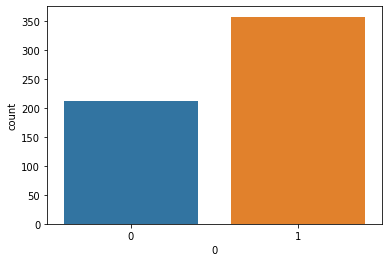

In [23]:
sns.countplot(classe['0']);

In [24]:
classe.shape

(569, 1)

In [25]:
previsores = np.array(previsores, dtype='float32')

# Precisamos usar o squeeze para ser um array unidimensional
classe = np.array(classe,dtype='float32').squeeze(1)

In [26]:
classe.shape

(569,)

In [27]:
type(previsores)

numpy.ndarray

In [28]:
type(classe)

numpy.ndarray

## Etapa 3: Classe para estrutura da rede neural

In [38]:
# O Pytorch não tem um método nativo de cross-validation / k-folding

# É necessário criar uma classe que herde da nn.Module
class rede_neural(nn.Module):
  def __init__(self):
    super().__init__()

    # Arquitetura da rede será 30 -> 16 -> 16 ->1
    
    # Faremos a primeira camada que será 30 ->16
    self.dense0 = nn.Linear(30,16)

    # Antes a inicialização dos pesos se dava de maneira automática
    # Ao sobreescrever o iniciador da classe, precisamos inicializar manualmente 
    # Com pesos aleatórios de uma distribuição normal
    torch.nn.init.uniform_(self.dense0.weight)
    
    # Instanciamos a primeira função de ativação
    # 16
    self.activation0 = nn.ReLU()
    
    # Instanciamos a segunda camada
    # 16 -> 16
    self.dense1 = nn.Linear(16,16)
    
    # Instanciamos novamente os pesos aleatórios com distribuição normal
    # 16
    torch.nn.init.uniform_(self.dense1.weight)

    # Instanciamos a função de ativação da segunda camada
    # 16
    self.activation1 = nn.ReLU()

    # Instanciamos a camada de saída
    # 16 -> 1
    self.dense2 = nn.Linear(16,1)
    
    # Instanciamos pesos e ativação para camada de saída
    torch.nn.init.uniform_(self.dense2.weight)
    self.output = nn.Sigmoid()

  # Precisamos na sobreescrita da classe sobreescrever o forward com cada etapa instanciada anteriormente (exceto os pesos) passando a base de input
  def forward(self, inputs):
    inputs = self.dense0(inputs)
    inputs = self.activation0(inputs)
    inputs = self.dense1(inputs)
    inputs = self.activation1(inputs)
    inputs = self.dense2(inputs)
    inputs = self.output(inputs)

    return inputs # retorna as previsões





## Etapa 4: Skorch

In [39]:
# Precisamos transformar nossa rede neural em sklearn para poder executar o cross-validor

rede_neural_sklearn = NeuralNetBinaryClassifier(module=rede_neural,
                                                  criterion=torch.nn.BCELoss,
                                                  optimizer=torch.optim.Adam,
                                                  lr=0.001,
                                                  optimizer__weight_decay=0.0001,
                                                  max_epochs=100,
                                                  batch_size=10,
                                                  train_split=False)

## Etapa 5: Validação cruzada

In [40]:
# Para executar o cross_validation usamos o cross_val_score do SKLEARN
# Perceba que como nossa rede que será executada é sklearn, os previsores e a classe são em numpy
# Se executássemos em torch direto, seriam tensors
resultados = cross_val_score(rede_neural_sklearn, previsores, classe, cv = 10, scoring = 'accuracy')

  epoch    train_loss     dur
-------  ------------  ------
      1       37.1094  0.3146
      2       37.1094  0.0750
      3       37.1094  0.0781
      4       37.1094  0.0749
      5       37.1094  0.0782
      6       37.1094  0.0862
      7       37.1094  0.0824
      8       37.1094  0.0793
      9       37.1094  0.0829
     10       37.1094  0.0786
     11       37.1094  0.0908
     12       37.1094  0.0778
     13       37.1094  0.0932
     14       37.1094  0.0809
     15       37.1094  0.0809
     16       37.1094  0.0753
     17       37.1094  0.0841
     18       37.1094  0.0748
     19       37.1094  0.0783
     20       37.1094  0.0758
     21       37.1094  0.0834
     22       37.1094  0.0821
     23       37.1094  0.1018
     24       37.1094  0.0747
     25       37.1094  0.0744
     26       11.7523  0.0757
     27        0.5200  0.0737
     28        0.4957  0.0758
     29        0.4800  0.0793
     30        0.4582  0.0843
     31        0.4450  0.0757
     32   

In [41]:
resultados.shape

(10,)

In [42]:
resultados

array([0.87719298, 0.80701754, 0.63157895, 0.63157895, 0.85964912,
       0.84210526, 0.89473684, 0.9122807 , 0.9122807 , 0.85714286])

In [43]:
media = resultados.mean()
media

0.8225563909774436

In [44]:
desvio = resultados.std()
desvio

0.10021803981657433

## Etapa 6: Dropout

In [47]:
# Aplicaremos a técnica de dropout que consiste em aleatóriamente excluir durante a época neurônios aleatórios da rede para evitar overfitting
# Utilizaremos como base a rede criada anteriormente com cross-validation
# O truque é que adicionaremos etapas de dropout após as funções de ativação das camadas densas



In [49]:
# O Pytorch não tem um método nativo de cross-validation / k-folding

# É necessário criar uma classe que herde da nn.Module
class rede_neural_cvdropout(nn.Module):
  def __init__(self):
    super().__init__()

    # Arquitetura da rede será 30 -> 16 -> 16 ->1
    
    # Faremos a primeira camada que será 30 ->16
    self.dense0 = nn.Linear(30,16)

    # Antes a inicialização dos pesos se dava de maneira automática
    # Ao sobreescrever o iniciador da classe, precisamos inicializar manualmente 
    # Com pesos aleatórios de uma distribuição normal
    torch.nn.init.uniform_(self.dense0.weight)
    
    # Instanciamos a primeira função de ativação
    # 16
    self.activation0 = nn.ReLU()
    
    # dropout da primeira camada oculta
    # Utilizaremos 20% de dropout
    self.dropout0 = nn.Dropout(0.2)

    # Instanciamos a segunda camada
    # 16 -> 16
    self.dense1 = nn.Linear(16,16)
    
    # Instanciamos novamente os pesos aleatórios com distribuição normal
    # 16
    torch.nn.init.uniform_(self.dense1.weight)

    # Instanciamos a função de ativação da segunda camada
    # 16
    self.activation1 = nn.ReLU()

    # dropout da segunda camada oculta
    # Utilizaremos 20% de dropout
    self.dropout1 = nn.Dropout(0.2)

    # Instanciamos a camada de saída
    # 16 -> 1
    self.dense2 = nn.Linear(16,1)
    
    # Instanciamos pesos e ativação para camada de saída
    torch.nn.init.uniform_(self.dense2.weight)
    self.output = nn.Sigmoid()

  # Precisamos na sobreescrita da classe sobreescrever o forward com cada etapa instanciada anteriormente (exceto os pesos) passando a base de input
  def forward(self, inputs):
    inputs = self.dense0(inputs)
    inputs = self.activation0(inputs)
    inputs = self.dropout0(inputs) # Dropout
    inputs = self.dense1(inputs)
    inputs = self.activation1(inputs)
    inputs = self.dropout1(inputs) # Dropout 
    inputs = self.dense2(inputs)
    inputs = self.output(inputs)

    return inputs # retorna as previsões





In [50]:
rede_neural_sklearn_cvdropout = NeuralNetBinaryClassifier(module=rede_neural_cvdropout, 
                                                          criterion = torch.nn.BCELoss,
                                                          optimizer = torch.optim.Adam,
                                                          lr=0.001,
                                                          optimizer__weight_decay=0.0001,
                                                          max_epochs=100,
                                                          batch_size=10,
                                                          train_split=False
                                                          )

In [51]:
resultados = cross_val_score(rede_neural_sklearn_cvdropout,previsores,classe,cv = 10, scoring='accuracy')

  epoch    train_loss     dur
-------  ------------  ------
      1       37.1094  0.0993
      2       37.1094  0.0931
      3       37.1094  0.0858
      4       37.1094  0.0843
      5       37.1094  0.0828
      6       37.1094  0.0911
      7       37.1094  0.0835
      8       37.1094  0.0896
      9       37.1094  0.0900
     10       37.1094  0.0863
     11       37.1094  0.0819
     12       37.1094  0.0951
     13       37.1094  0.0930
     14       37.1094  0.0908
     15       37.1094  0.0851
     16       37.1094  0.0945
     17       37.1094  0.0896
     18       37.1094  0.0851
     19       37.1094  0.0855
     20       37.1094  0.0918
     21       37.1094  0.0882
     22       37.1094  0.0830
     23       36.9438  0.0915
     24       37.1094  0.0947
     25       37.1094  0.0974
     26       36.9439  0.0905
     27       20.8338  0.0834
     28        0.6024  0.0935
     29        0.5696  0.0907
     30        0.5610  0.0845
     31        0.5301  0.0908
     32   

In [52]:
media_cvdropout = resultados.mean()
desvio_cvdropout = resultados.std()
media_cvdropout, desvio_cvdropout

(0.8506578947368422, 0.07609649122807016)

In [63]:
print("O ganho de dropout na média foi: ")
print(media_cvdropout - media)
print("A queda de std no dropout foi: ")
print(desvio_cvdropout - desvio)

O ganho de dropout na média foi: 
0.02810150375939857
A queda de std no dropout foi: 
-0.02412154858850417


In [64]:
resultados

array([0.85964912, 0.80701754, 0.85964912, 0.9122807 , 0.87719298,
       0.84210526, 0.87719298, 0.94736842, 0.64912281, 0.875     ])